# Лабораторная работа: Спайковые нейронные сети

# Теоретическая часть

## 1. Суть нейроморфных вычислений и спайковых нейронных сетей

Нейроморфные вычисления — это парадигма, направленная на создание вычислительных систем, архитектура и принципы работы которых вдохновлены биологическим мозгом. В отличие от классических нейронных сетей, которые оперируют непрерывными значениями активаций (например, вещественными числами), спайковые нейронные сети (Spiking Neural Networks, SNN) используют **дискретные события во времени** — спайки (или потенциалы действия).

Основная цель нейроморфных систем — достичь высокой **энергоэффективности** и способности эффективно обрабатывать **временно́зависимые данные** (аудио, видео, сенсорные потоки), что критически важно для задач встраиваемого ИИ, робототехники и интерфейсов мозг-компьютер.


## 2. Модель нейрона LIF (Leaky Integrate-and-Fire)

Модель LIF является одной из самых распространенных и вычислительно эффективных моделей спайкового нейрона. Она описывает динамику мембранного потенциала $V(t)$.

Уравнение мембранного потенциала:

$$
\tau_m \frac{dV(t)}{dt} = -(V(t) - V_{rest}) + R_m I(t)
$$

где:
- $V(t)$ — мембранный потенциал в момент времени $t$,
- $\tau_m = R_m C_m$ — постоянная времени мембраны (произведение сопротивления $R_m$ и емкости $C_m$),
- $V_{rest}$ — потенциал покоя,
- $R_m$ — мембранное сопротивление,
- $I(t)$ — суммарный входной ток (от синапсов).

При достижении порогового потенциала $V_{th}$ нейрон генерирует спайк, и его потенциал сбрасывается до потенциала покоя $V_{rest}$ на период рефрактерности $\tau_{ref}$:

$$
\text{if } V(t) \geq V_{th} \text{, then:} \\
V(t) \rightarrow V_{rest} \\
\text{Запрет на срабатывание на время } \tau_{ref}
$$

## 3. Спайк-тайм-зависимая пластичность (STDP)

STDP — это биоинспирированное правило обучения, которое модифицирует силу синаптической связи (вес $w$) на основе временной корреляции между спайками пресинаптического и постсинаптического нейронов.

Формально, изменение веса $\Delta w$ определяется так:

$$
\Delta w =
\begin{cases}
A_{+} \cdot \exp\left(-\frac{\Delta t}{\tau_{+}}\right), & \text{если } \Delta t > 0 \text{ (пре-спайк до пост-спайка)} \\
-A_{-} \cdot \exp\left(-\frac{|\Delta t|}{\tau_{-}}\right), & \text{если } \Delta t < 0 \text{ (пре-спайк после пост-спайка)}
\end{cases}
$$

где:
- $\Delta t = t_{post} - t_{pre}$ — разница во времени между постсинаптическим и пресинаптическим спайками,
- $A_{+}, A_{-}$ — амплитуды усиления и ослабления связи,
- $\tau_{+}, \tau_{-}$ — временные константы для потенциации и депрессии.

STDP реализует принцип Хебба: *"Neurons that fire together, wire together"* (Нейроны, которые возбуждаются вместе, связываются вместе).

## Практическая часть

В данной работе вам предлагается реализовать и исследовать простую спайковую нейронную сеть на основе модели LIF с обучением по правилу STDP. Вы должны:

1.  Реализовать модель LIF-нейрона и исследовать его отклик на различные входные токи.
2.  Создать сеть из нескольких LIF-нейронов (например, входной слой, скрытый слой) и визуализировать распространение спайковой активности.
3.  Реализовать правило обучения STDP для синаптических связей.
4.  Обучить сеть на простой задаче (например, ассоциации паттернов) или классификации простых спайковых последовательностей.
5.  Проанализировать динамику весов, итоговую активность сети и эффективность обучения.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

In [2]:
# Определение параметров нейрона LIF
@dataclass
class LIFNeuron:
    tau_m: float = 20.0    # Постоянная времени мембраны (мс)
    v_rest: float = -70.0  # Потенциал покоя (мВ)
    v_thresh: float = -55.0 # Пороговый потенциал (мВ)
    v_reset: float = -75.0 # Потенциал сброса (мВ)
    r_m: float = 10.0      # Мембранное сопротивление (МОм)
    tau_ref: float = 4.0   # Рефрактерный период (мс)

    def __post_init__(self):
        self.v = self.v_rest
        self.refractory_until = 0
        self.spike_times = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        """Один шаг интегрирования. Возвращает True, если был спайк."""
        # Проверка рефрактерности
        if t < self.refractory_until:
            self.v = self.v_reset
            return False

        # Интегрирование уравнения LIF (простая Эйлерова схема)
        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt

        # Проверка на срабатывание
        if self.v >= self.v_thresh:
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        return False

In [3]:
# Функция для визуализации потенциала и спайков
def plot_neuron_activity(t_range: np.ndarray, v_trace: List[float], spike_times: List[float]):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax1.plot(t_range, v_trace, 'b-', label='Мембранный потенциал')
    ax1.axhline(y=neuron.v_thresh, color='r', linestyle='--', label='Порог')
    ax1.axhline(y=neuron.v_rest, color='g', linestyle='--', label='Покой')
    ax1.set_ylabel('Потенциал (мВ)')
    ax1.legend()
    ax1.grid(True)

    ax2.eventplot(spike_times, colors='k', linewidths=2)
    ax2.set_xlabel('Время (мс)')
    ax2.set_ylabel('Спайки')
    ax2.set_yticks([])
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

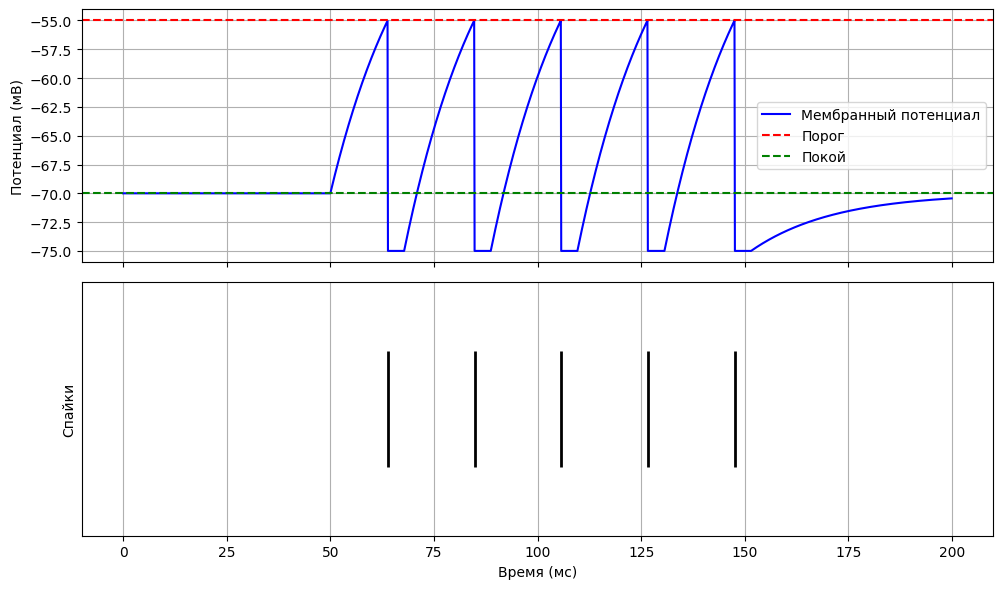

Количество спайков: 5


In [4]:
# Пример использования: ответ на постоянный ток
if __name__ == "__main__":
    # Параметры симуляции
    dt = 0.1  # шаг по времени (мс)
    T = 200   # общее время симуляции (мс)
    t_range = np.arange(0, T, dt)

    # Создание нейрона
    neuron = LIFNeuron()

    # Входной ток: ступенька
    I_inj = np.zeros_like(t_range)
    I_inj[(t_range > 50) & (t_range < 150)] = 3.0  # nA

    # Симуляция
    v_trace = []
    spike_times = []

    for i, t in enumerate(t_range):
        spike = neuron.step(I_inj[i], dt, t)
        v_trace.append(neuron.v)
        if spike:
            spike_times.append(t)

    # Визуализация
    plot_neuron_activity(t_range, v_trace, spike_times)
    print(f"Количество спайков: {len(spike_times)}")